# ST446 Distributed Computing for Big Data
## Assignment 2 -  PART 2
---

## P2: Spark streaming

_You may use a GCP compute engine or your own computer._

In this homework problem your task is to track the sample mean and unbiased sample variance of the number of words per tweet using the Spark streaming API. 

**P2.1 (10 points)** Write functions to calculate the mean and variance for all the tweets that you receive over time, not just for the last received batch of the stream. This means that you need to calculate the mean and the variance recursively using the Spark streaming concept of a "stateful" operation.

Note that you may also use `nc` to manually stream messages instead of using the twitter stream, if you have trouble getting the twitter stream to run.

**P2.2 (10 points)** Calculate two different versions of sample mean and variance estimators with different step sizes:

**Decaying step size**: Recursive evaluations of mean and unbiased sample variance for an input stream of observations $x_1, x_2, \ldots$ with decaying step size:

* Mean: $m_{n+1} = (1-w_n) m_n + w_n x_{n+1}$ where $w_n = 1/(n+1)$.
* Sample variance: $\sigma^2_{n+1} = a_n \sigma^2_n + b_n (x_{n+1}-m_n)^2$ where $a_n$ and $b_n$ are two sequences whose values you need to work out first.

**Fixed step size**: Recursive evaluation with fixed step size (exponentially weighted smoothing):

* Mean: same as above but with $w_n = 0.2$ for all $n$
* Sample variance: same as above with $a_n = 1 - b_n$ and $b_n = 0.2$ for all $n$

**P2.3 (5 points)** Document both versions of the code and how you got it to run (on a cluster or on your own computer). You do not need to run the code in a notebook. Please show all the code and some of the streaming output that you have obtained from running it on live data.

## How to get Twitter data or set up a stream using `nc`

Please see the exercise from one of our class sessions for guidance on how to receive a live Twitter data stream: https://github.com/lse-st446/lectures2021/blob/main/Week07/class/streaming_examples.md and the Python scripts in the same directory.

#### My Solution

The formulas for updating the mean and variance are based on a one-by-one stream of tweets. However, Spark streaming uses discretized streams (DStreams), so what really needs to be processed is a batch of tweets per time interval. 

The most simple solution to this issue is to use a for loop inside the `updateFunction`. Alternatively, one may also adapt the formula such that a single update is performed using the new mean of all incoming tweets during a given time interval in combination with the number of new tweets.

I decided to go with the former approach due to its simplicity. A downside, however, could be that the for loop may not be fast enough if the number of new tweets was very large. Because I only stream tweets containing the word "_London_", this number is generally not very large (a few tweets per second) and therefore does not cause a problem.

#### Recursive evaluation of the sample variance
For calculating the sample variance in a recursive/online way, we can use _Welford's online algorithm_.

$$
\sigma_{n+1}^2 = \frac{n}{n+1} \sigma_n + \frac n{(n+1)^2} (x_{n+1}-m_n)^2 = a_n\sigma_n + b_n(x_{n+1}-m_n)^2
$$

where $a_n=\frac{n}{n+1}$ and $b_n=\frac n{(n+1)^2}$. I was not able to derive these result myself, but some information and derivations can be found [here](https://changyaochen.github.io/welford/).

As an alternative, we may also use $a_n=\frac{n-1}{n}$ and $b_n=\frac 1{(n+1)}$.

#### Cluster Setup
```shell
gcloud beta dataproc clusters create mycluster-lda --project st446-lse-2021 \
    --bucket st446-mybucket --region europe-west2 \
    --master-machine-type n1-standard-4 --master-boot-disk-size 500 \
    --num-workers 2 --worker-machine-type n1-standard-4 --worker-boot-disk-size 250 \
    --image-version=1.4-debian10 \
    --optional-components=ANACONDA,JUPYTER \
    --enable-component-gateway \
    --initialization-actions \
    gs://goog-dataproc-initialization-actions-europe-west2/python/pip-install.sh,gs://st446-mybucket/my-actions.sh \
    --metadata 'PIP_PACKAGES=sklearn nltk pandas numpy'
```

#### Shell commands on the VM
```shell
# TAB 0: start kafka
cd /usr/lib/kafka
sudo -s
bin/kafka-server-start.sh config/server.properties &

# TAB 1: run kafka_twitter_producer.py
python kafka_twitter_producer.py

# TAB 2: run kafka_twitter_pyspark.py
# first add the jar file 
cd $SPARK_HOME
sudo nano $SPARK_HOME/conf/spark-defaults.conf
# add to the end: spark.jars.packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.0
unset PYSPARK_DRIVER_PYTHON
bin/spark-submit ~/kafka_twitter_pyspark.py
```

#### Code
For the Python implementation of the Kafka producer and the Pyspark consumer, see the files *kafka_twitter_producer.py* and *kafka_twitter_pyspark.py*, respectively.

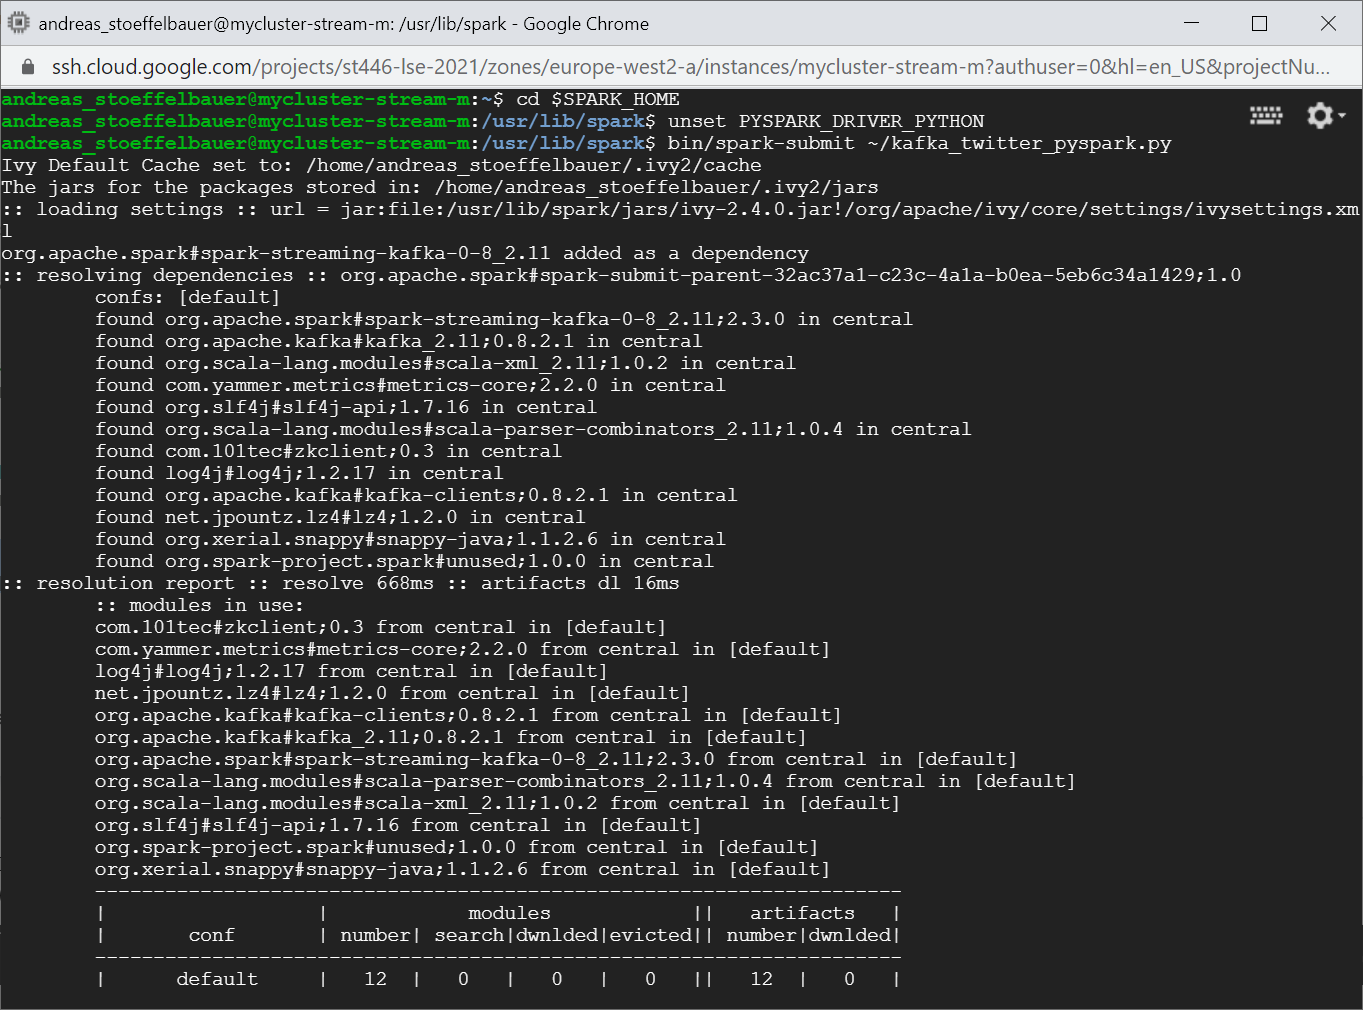

In [4]:
from IPython.display import Image
Image(filename='images/commands.png') 

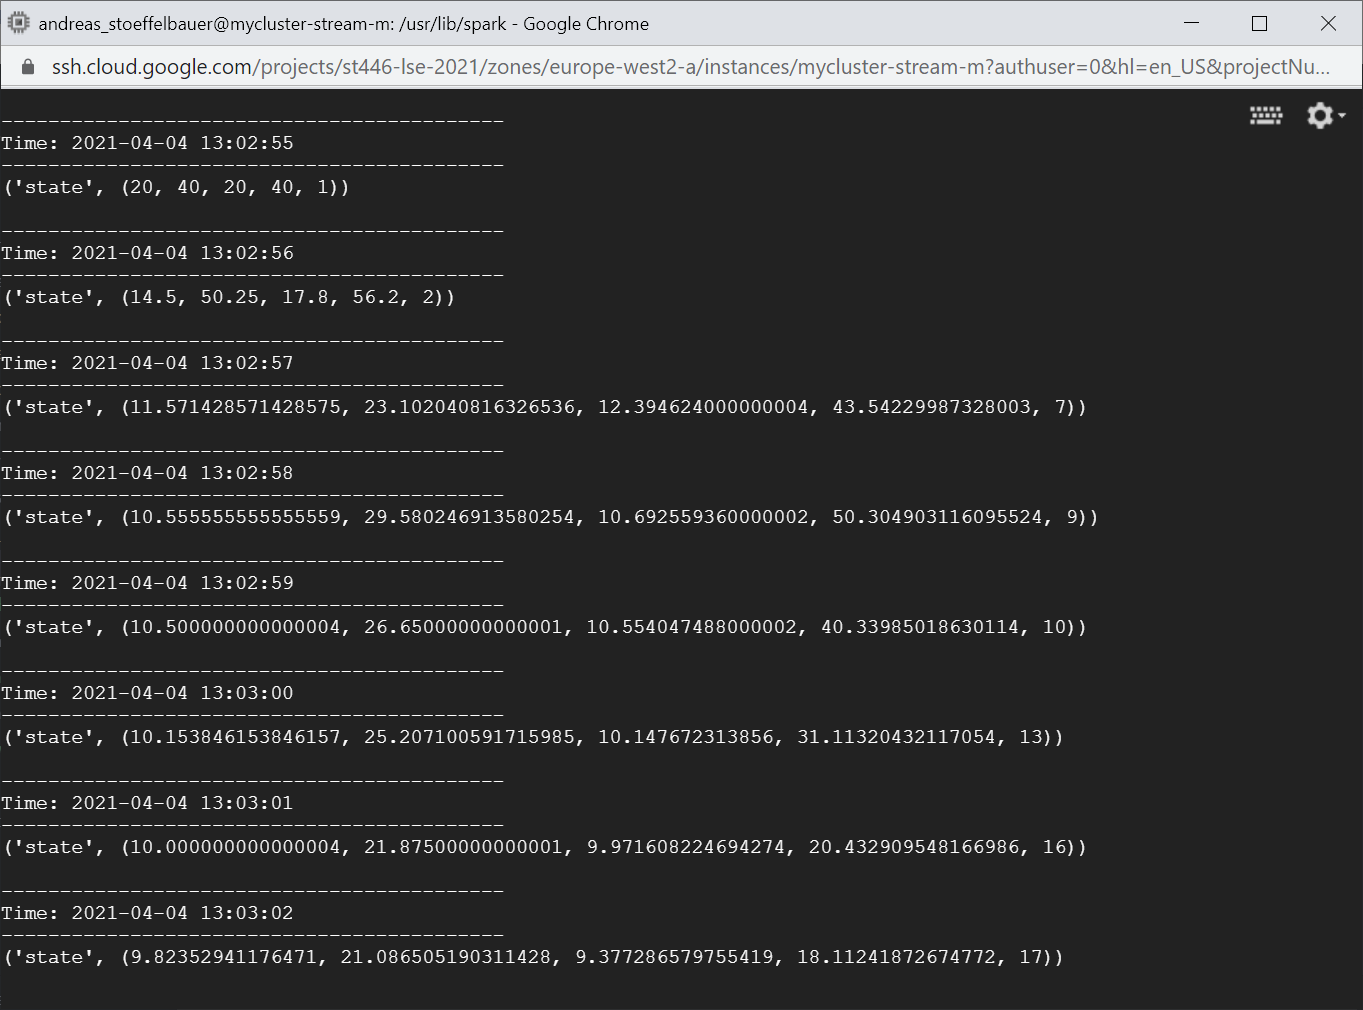

In [5]:
Image(filename='images/output.png') 